# Test 12

_Contar vértices pero barriendo todos los ángulos_

Es lo mismo que hice al inicio, solo que no quería arreglar los scripts viejos.

**Simulation with LAMMPS**

Simulations are done by a rotation in 60s + Evolution (60s)

**Analysis**

Vertices counts.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = True


# MD Simulations

This part only generates the datasets to work with for all angles.

In [8]:
params = {
    "particle_radius":5*ureg.um,
    "particle_susceptibility":0.0576,
    "particle_diffusion":0.125*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":10*ureg.um,
    "trap_height":4*ureg.pN*ureg.nm,
    "trap_stiffness":1e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,
    
    "total_time":120*ureg.s,
    "framespersec":20*ureg.Hz,
    "dt":10*ureg.ms,
    "max_field":7*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
    
    "lattice_constant":30*ureg.um,
    "size" : 10
}

In [4]:
def get_md_colloid(params,realization):
    sp = ice.spins()
    
    N = params["size"]
    a = params["lattice_constant"]
    
    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

    particle = ice.particle(radius = params["particle_radius"],
                susceptibility = params["particle_susceptibility"],
                diffusion = params["particle_diffusion"],
                temperature = params["particle_temperature"],
                density = params["particle_density"])

    trap = ice.trap(trap_sep = params["trap_sep"],
                height = params["trap_height"],
                stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = params["height_spread"], 
                            susceptibility_spread = params["susceptibility_spread"],
                            periodic = params["isperiodic"])

        
    col.randomize()
    col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a


    world = ice.world(
            field = params["max_field"],
            temperature = params["sim_temp"],
            dipole_cutoff = params["sim_dipole_cutoff"],
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = f"lammps_files/test{realization}",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framespersec"],
                timestep = params["dt"],
                run_time = params["total_time"],
                output = ["x","y","z","mux","muy","muz"],
                processors=1)

    # Field
        
    #col.sim.field.fieldx = "v_Bmag*sin(PI/2/60*time/1e6)*(time<60e6)+v_Bmag*(time>=60e6) "
    #col.sim.field.fieldy = "0"
    #col.sim.field.fieldz = "v_Bmag*cos(PI/2/60*time/1e6)*(time<60e6)+0*(time>=60e6)"
    
    col.sim.field.fieldx = "v_Bmag*sin(PI/2/60*(time-60e6)/1e6)*(time>=60e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "v_Bmag/60e6*time*(time<60e6)+v_Bmag*cos(PI/2/60*(time-60e6)/1e6)*(time>=60e6)"        


    col.run_simulation()

    col.load_simulation()

    return col

In [5]:
def jesus_take_the_wheels(params,data_path,realization):
    trj_path = data_path + "/trj/"
    ctrj_path = data_path + "/ctrj/"

    try:
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,realization)

    filename = f"trj{realization}.csv"
    col.trj.to_csv(trj_path + filename)

    filename = f"ctrj{realization}.csv"
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(ctrj_path + filename)
    
    return None

# MD Sims

This block checks which angles are going to be ran. Helps for running by batches.

In [6]:
import concurrent.futures

In [ ]:
runs = 10
data_path = "../data/test13"
realizations = list(range(1,runs+1))
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    # map the function to the realizations
    results = list(
        executor.map(
            jesus_take_the_wheels,
            [params] * len(realizations),
            [data_path] * len(realizations),
            realizations,
        )
    )

This section graphs the fields just to check that everything is OK.

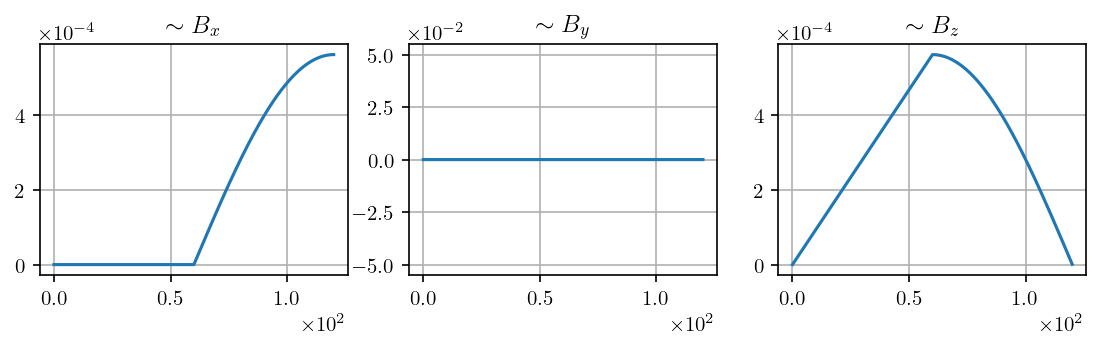

In [3]:
trj_raw = trj = pd.read_csv("../data/test13/trj/trj10.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test13/ctrj/ctrj10.csv", index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

In [9]:
trjPath = "../data/test13/trj/"
ctrjPath = "../data/test13/ctrj/"
verticesPath = "../data/test13/vertices/"

# Get the number of realizations
_, _, files = next(os.walk(trjPath))
realizations = len(files)

for i in range(1,realizations+1):
    print("========================================")
    print(f"Working on realization {i}")

    # Importing files
    trjFile = trjPath + f"trj{i}.csv"
    print(f"Opening " + trjFile)
    ctrjFile = ctrjPath + f"ctrj{i}.csv"
    print(f"Opening " + ctrjFile)
    trj_raw = trj = pd.read_csv(trjFile, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrjFile, index_col=[0,1])

    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    verticesFile = verticesPath + f"vertices{i}.csv"
    v.trj_to_vertices(ctrj_raw.loc[frames[::5]])

    print(f"Saving vertices to " + verticesFile)
    v.vertices.to_csv(verticesFile)
    
    clear_output(wait=True)

Working on realization 10
Opening ../data/test13/trj/trj10.csv
Opening ../data/test13/ctrj/ctrj10.csv


100%|██████████| 480/480 [05:06<00:00,  1.57it/s]


Saving vertices to ../data/test13/vertices/vertices10.csv


# Analysis

In [4]:
# Import and classify the vertices
vrt_path = "../data/test13/vertices/"
vertices = aux.getVerticesDict(vrt_path)
vertices["10"]

x      y  coordination  charge            dx   dy type
frame vertex                                                            
0     3       120.0  270.0             4       2  2.000000e+00  0.0    V
      4       270.0  270.0             4      -2 -1.224646e-16 -2.0   II
      5       270.0  240.0             4       0  0.000000e+00  0.0  III
      10      270.0  210.0             4      -2  1.224646e-16  2.0   II
      11      270.0  180.0             4      -4  0.000000e+00  0.0    I
...             ...    ...           ...     ...           ...  ...  ...
2395  94      240.0  210.0             4      -4  0.000000e+00  0.0    I
      95      240.0   30.0             4      -4  0.000000e+00  0.0    I
      96      240.0   60.0             4       4  0.000000e+00  0.0   VI
      97       30.0   60.0             4      -2 -1.224646e-16 -2.0   II
      98       60.0   60.0             4       0  2.000000e+00  2.0   IV

[38880 rows x 7 columns]

In [5]:
counts = aux.getVerticesCount(vertices)
counts["2"]

number  fraction
frame type                  
0     I          3  0.037037
      II        23  0.283951
      III        9  0.111111
      IV        20  0.246914
      V         24  0.296296
...            ...       ...
2395  II         8  0.098765
      III        0  0.000000
      IV         4  0.049383
      V         13  0.160494
      VI        28  0.345679

[2880 rows x 2 columns]

In [10]:
vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
types = vrt_ts.columns.to_list()[1:]
t = vrt_ts["time"].to_numpy()
vrt_counts = vrt_ts[types].to_numpy()

/home/leogabac/.local/lib/python3.8/site-packages/pandas/core/construction.py:580: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


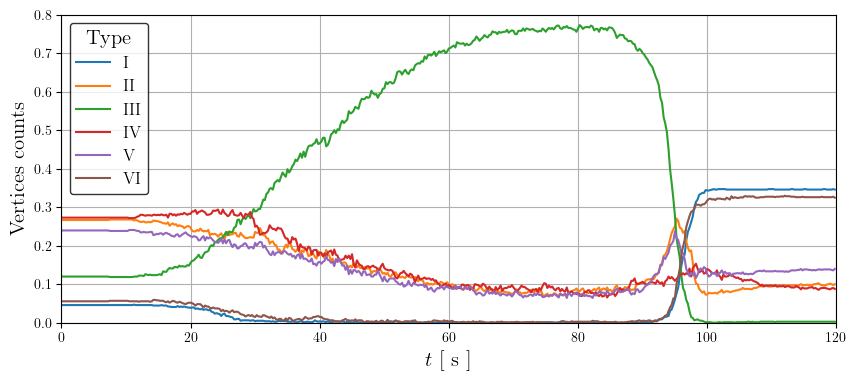

In [13]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(t,vrt_counts[:,0])
ax.plot(t,vrt_counts[:,1])
ax.plot(t,vrt_counts[:,2])
ax.plot(t,vrt_counts[:,3])
ax.plot(t,vrt_counts[:,4])
ax.plot(t,vrt_counts[:,5])

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')
ax.set_xlabel("$t$  [ s ] ", fontsize=15)
ax.set_ylabel("Vertices counts", fontsize=15)
ax.set_xlim(0,120)
ax.set_ylim(0,0.8)
plt.show()

fig.savefig('../data/vertices_full.pdf', bbox_inches='tight')
fig.savefig('../data/vertices_full.jpeg', dpi=300)

In [15]:
b = t>=60
t_rot = t[b]
counts_rot = vrt_counts[b,:]
rot_angle = 90/60*(t_rot-60) # degrees


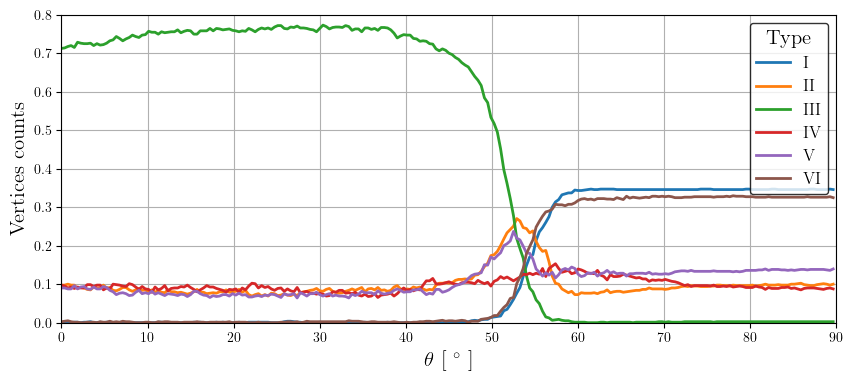

In [17]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(rot_angle,counts_rot[:,0], lw=2.0)
ax.plot(rot_angle,counts_rot[:,1], lw=2.0)
ax.plot(rot_angle,counts_rot[:,2], lw=2.0)
ax.plot(rot_angle,counts_rot[:,3], lw=2.0)
ax.plot(rot_angle,counts_rot[:,4], lw=2.0)
ax.plot(rot_angle,counts_rot[:,5], lw=2.0)

ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black', loc='upper right')
ax.set_xlabel("$\\theta$  [ $^\\circ$ ] ", fontsize=15)
ax.set_ylabel("Vertices counts", fontsize=15)
ax.set_xlim(0,90)
ax.set_ylim(0,0.8)
plt.show()

fig.savefig('../data/vertices.pdf', bbox_inches='tight')
fig.savefig('../data/vertices.jpeg', dpi=300)